**Imports**

In [1]:
import math
import numpy as np

**Engine**

In [2]:
class Value:
  
  def __init__(self, data, children=(), operation='', label=''):
    self.data = data
    self.children = children
    self.operation = operation
    self.label = label
    self.grad = 0
    self.derivative = lambda: None

  # Create a printable representation
  def __repr__(self):
    return f"Value({self.data})"
  
  # Self + Other
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def derivative():
      self.grad += 1 * out.grad
      other.grad += 1 * out.grad
    out.derivative = derivative
    
    return out

  # Other + Self
  def __radd__(self, other): # other + self
    return self + other

  # Self * Other
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def derivative():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out.derivative = derivative
      
    return out

  # Other * Self
  def __rmul__(self, other): # other * self
    return self * other
  
  # Self ** Other
  def __pow__(self, other):
    out = Value(self.data**other, (self, ), f'**{other}')

    def derivative():
      self.grad += other * (self.data ** (other - 1)) * out.grad
    out.derivative = derivative

    return out
  
  # Self / Other
  def __truediv__(self, other):
    return self / other

  # Negate self: self --> -self
  def __neg__(self):
    return self * -1

  # Self - Other
  def __sub__(self, other):
    return self + (-other)

  # Exponent
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def derivative():
      self.grad += out.data * out.grad
    out.derivative = derivative
    
    return out

  # Activation fn --> tanh
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def derivative():
      self.grad += (1 - t**2) * out.grad
    out.derivative = derivative
    
    return out
  
  # Backward fn
  def backward(self):

    # Topological order
    topo = [] 
    visited = set() 
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v.children:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    # Initialize gradient
    self.grad = 1.0

    # Perform backpropagation
    for node in reversed(topo):
      node.derivative()

**Neural Network**

In [3]:
# Create a neuron
class Neuron:
  
  def __init__(self, _in):
    self.w = [Value(np.random.uniform(-1, 1)) for _ in range(_in)]
    self.b = Value(np.random.uniform(-1, 1))
  
  def __call__(self, x):
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def params(self):
    return self.w + [self.b]

# Create a layer of neurons
class Layer:
  
  def __init__(self, _in, _out):
    self.neurons = [Neuron(_in) for _ in range(_out)]
  
  def __call__(self, x):
    _out = [n(x) for n in self.neurons]
    return _out[0] if len(_out) == 1 else _out
  
  def params(self):
    return [p for neuron in self.neurons for p in neuron.params()]

# Create a Feedforward Neural Network
class FNN:
  
  def __init__(self, _in, __out):
    size = [_in] + __out
    self.layers = [Layer(size[i], size[i+1]) for i in range(len(__out))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def params(self):
    return [p for layer in self.layers for p in layer.params()]

**Trace Graph**

In [4]:
# This one i literally copy-pasted from the micrograd repo
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v.children:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n.operation:
      # if this value is a result of some operation, create an operation node for it
      dot.node(name = uid + n.operation, label = n.operation)
      # and connect this node to it
      dot.edge(uid + n.operation, uid)

  for n1, n2 in edges:
    # connect n1 to the operation node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2.operation)

  return dot

**Example 1**

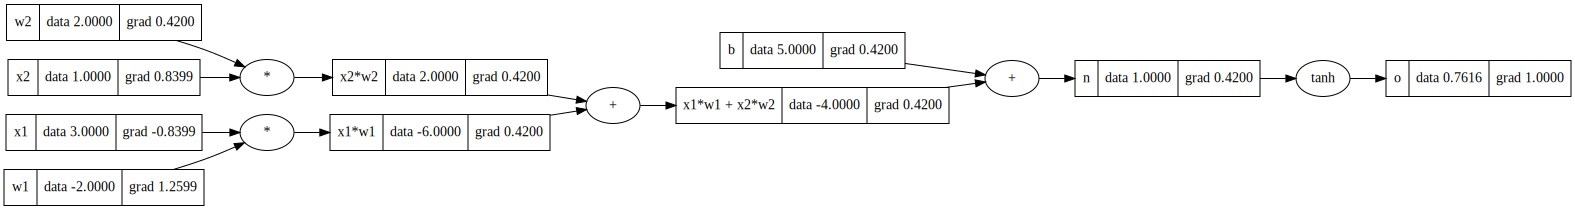

In [5]:
# Inputs
x1 = Value(3.0, label='x1')
x2 = Value(1.0, label='x2')
# Weights
w1 = Value(-2.0, label='w1')
w2 = Value(2.0, label='w2')
# Bias
b = Value(5, label='b')

# Forward pass
x1w1 = x1*w1
x1w1.label = 'x1*w1'

x2w2 = x2*w2
x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b
n.label = 'n'

o = n.tanh()
o.label = 'o'

# Backward pass
o.backward()

# Graph
draw_dot(o)

**Example 2**

In [6]:
# Create the neural network
nn = FNN(3, [4, 4, 1])

# Inputs
x = [[6.0, 1.0, -10.0],
     [-20.5, 6.5, -1.5],
     [0.5, -1.0, 10.0],
     [12.0, -20.0, -1.0]]

# Target outputs
y = [1.0, -1.0, -1.0, 1.0]

In [7]:
for i in range(100):
  
  # forward pass
  ypred = [nn(x) for x in x]
  loss = sum((ypred - ytrue)**2 for ytrue, ypred in zip(y, ypred))
  
  if loss.data < 0.02:
    break

  # backward pass
  for p in nn.params():
    p.grad = 0.0  # zerograd
  loss.backward()
  
  # update
  for p in nn.params():
    p.data += -5e-2 * p.grad
  
  print(f'Epoch: {i+1}, Loss: {loss.data}')

Epoch: 1, Loss: 6.290485134086017
Epoch: 2, Loss: 2.1704723141722884
Epoch: 3, Loss: 1.1876621400116987
Epoch: 4, Loss: 0.5940025122407685
Epoch: 5, Loss: 0.3449840472076281
Epoch: 6, Loss: 0.23142675124304465
Epoch: 7, Loss: 0.17056267723709134
Epoch: 8, Loss: 0.13363026556488378
Epoch: 9, Loss: 0.10916610902911855
Epoch: 10, Loss: 0.09190435233490166
Epoch: 11, Loss: 0.07913715335025219
Epoch: 12, Loss: 0.06934546475381778
Epoch: 13, Loss: 0.06161717443623875
Epoch: 14, Loss: 0.05537409753966146
Epoch: 15, Loss: 0.05023320939304437
Epoch: 16, Loss: 0.045931346088272124
Epoch: 17, Loss: 0.04228206949671646
Epoch: 18, Loss: 0.03914980623219774
Epoch: 19, Loss: 0.03643373014344996
Epoch: 20, Loss: 0.03405737642728219
Epoch: 21, Loss: 0.03196175205639392
Epoch: 22, Loss: 0.030100647677436705
Epoch: 23, Loss: 0.028437374909519936
Epoch: 24, Loss: 0.026942449688565753
Epoch: 25, Loss: 0.025591917540524062
Epoch: 26, Loss: 0.024366123162559022
Epoch: 27, Loss: 0.02324879309353833
Epoch: 28,

In [8]:
print(f'True labels: {y} \nPredictions: {ypred}')

True labels: [1.0, -1.0, -1.0, 1.0] 
Predictions: [Value(0.9262200125205117), Value(-0.9570245242648244), Value(-0.9162937958307105), Value(0.9270251746677287)]
